# Implementing a Key-Value Database

## Introduction

Throughout the course, we have been studying tree data structures, and we finished with a fully implemented B-tree that allows us to carry out lookups and basic operations (such as adding entries) in logarithmic time.
Our implementation of the B-tree class can be found in the `btree.py` file.

In this project, we'll use the B-tree data structure as a building block for a fully functioning **Key-value store**. This is a database that operates similarly to a Python dictionary, but it will also allow users to perform range queries. Our goal will be to create an easy-to-use, flexible, and adaptable key-value store that other developers could use in their projects.

To do this, we will extend the `BTree` class to implement a key-value store class named `KVStore`. We will also enable the `KVStore` class to allow square bracket syntax to set and access entries (e.g. `entry[key] = value` and `value = entry[key]`).
Like a dictionary, the key-value store won't allow two entries with the same key. Any entries with a duplicate key will overwrite the original entry.
We will also allow the keys to be any datatype that allows comparisons. This will make our data structure useful in a wide range of contexts.

## Extend the BTree Class and Override add() Method

Let's start by creating a `KVStore` class that extends the `BTree` class. In the new `KVStore`'s `__init__()` method, we'll call the `BTree`'s `__init__()` method to ensure all attributes are loaded. 

To make testing easier, we will fix our `split_threshold` to equal two. 

We'll also override the inherited `add()` method in cases where a new entry is added with a key that already exists. Here, we'll overwrite the existing entry instead of adding a new one.

In [1]:
# Extend the BTree class and allow CSV Reading upon instantiation
from btree import BTree
import bisect

class KVStore(BTree):

    def __init__(self):
        super().__init__(split_threshold=2) # Split threshold fixed at 2. Usually we'd allow it to be passed as an argument above.

    # Override the add() method from the BTree class
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
             # If it's a new key, just use the add() method from the BTree class.
            super().add(key, value)
        else:
            # If key already exists, overwrite the entry
            overwrite_index = node.keys.index(key)
            node.values[overwrite_index] = value


Let's test the `KVStore` class to make sure our functions work...

In [2]:
kv = KVStore()
assert kv.split_threshold == 2, 'The split threshold is not equal to 2.'

kv.add('a', 1)
assert kv.get_value('a') == 1, 'The value was not stored correctly'

kv.add('a', 2)
assert kv.get_value('a') == 2, 'The value did not update correctly'

## Implementing the Item Getter and Setter

Let's make the `KVStore` easier to use by allowing users to use the bracket syntax to add entries and retrieve values. This allows them to interact with the B-tree data structure in the same way as a dictionary, which they may be more used to.

In [3]:
from btree import BTree
import bisect

class KVStore(BTree):

    def __init__(self):
        super().__init__(split_threshold=2) 
   
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            overwrite_index = node.keys.index(key)
            node.values[overwrite_index] = value
            
    # Allow retrieval of values using square brackets
    def __getitem__(self, key):
        return self.get_value(key)
    
    # Allow creation and modification of values using square brackets
    def __setitem__(self, key, value):
        self.add(key, value)
            
    

Let's run the same tests we did before but using the bracket syntax...

In [4]:
kv = KVStore()

kv['a'] = 1
assert kv['a'] == 1, 'The value was not stored correctly'

kv['a'] = 2
assert kv['a'] == 2, 'The value did not update correctly'

## Enhancing the Contains Method

Here, we will continue to expand the functionality of the `KVStore` to enable to ability to use the `in` operator to check whether a given key is stored. This is another common dictionary feature.

In [5]:
from btree import BTree
import bisect

class KVStore(BTree):

    def __init__(self):
        super().__init__(split_threshold=2) 
   
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            overwrite_index = node.keys.index(key)
            node.values[overwrite_index] = value
            
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    # Allow the use of the in operator
    def __contains__(self, key):
        return self.contains(key)
    

Let's perform some tests on our `__contains__()` method...

In [6]:
kv = KVStore()

kv['hello'] = 'hello'
kv['world'] = 'world'

assert 'hello' in kv, 'in operator is not working as intended.'
assert 'world' in kv, 'in operator is not working as intended.'

## Implement Range Queries

One of the most helpful properties of the `KVStore` class will be that it allows us to perform range queries. This will allow users to select entries within a specified range (for example, selecting all entries with keys between 1 and 10).

Now, we'll implement a `_range_query()` method to return all values with keys within a given range. This uses an auxiliary method, `_range_intersects`, that allows us to compare the query range to the current node's possible key range, even when there is no minimum or maximum possibility.

Users shouldn't have to know the internal structure of the tree, so will also create a `range_query()` helper method that allows users to only enter the range start and end values. This means that they won't have to worry about providing the `current_node`, `min_key` and `max_key` values.

In [7]:
from btree import BTree
import bisect

class KVStore(BTree):

    def __init__(self):
        super().__init__(split_threshold=2) 
   
    def add(self, key, value):
        node = self._find_node(self.root, key)
        if node is None:
            super().add(key, value)
        else:
            overwrite_index = node.keys.index(key)
            node.values[overwrite_index] = value
            
    def __getitem__(self, key):
        return self.get_value(key)
    
    def __setitem__(self, key, value):
        self.add(key, value)
        
    def __contains__(self, key):
        return self.contains(key)
        
    # Implement internal method to allow range queries
    def _range_query(self, range_start, range_end, current_node, min_key, max_key): # min_key/max_key = minimum/maximum key possible in subtree
        # Base case: when the query range no longer intersects with the subtree possible range
        if not self._range_intersects(range_start, range_end, min_key, max_key):
            return []
        
        # General case:
        results = []
        for i, key in enumerate(current_node.keys):
            if range_start <= key and key <= range_end:
                results.append(current_node.values[i])
                
                # Make sure current node isn't a leaf, and therefore has children to recursively perform search on.
            if not current_node.is_leaf():
                for i, child in enumerate(current_node.children):
                    # New minimum possible key in subtree is the node key to the left of the current child. Unless the current child is the first, then the min key is still -infinity.
                    new_min_key = current_node.keys[i - 1] if i > 0 else min_key
                    # New maximum possible key in subtree is the node key to the right of the current child. Unless the current child is the last, then the max key is still +infinity.
                    new_max_key = current_node.keys[i] if i < len(current_node) else max_key

                    # apply the _range_query() method recursively to each child in the current node and combine the results with the root node results
                    # Use the new_min_key and new_max_key to narrow down the possible keys within the subtrees recursively
                    results += self._range_query(range_start, range_end, child, new_min_key, new_max_key)
                        
        return results
    
    # An auxiliary method that checks whether the range intersects with the minimum and maximum keys possible in any given subtree.
    # It treats None as always smaller than range end and always greater than range start.
    def _range_intersects(self, range_start, range_end, min_key, max_key):
        if min_key is not None and min_key > range_end:
            return False
        if max_key is not None and max_key < range_start:
            return False
        return True
    
    # Implement the range_query() helper function
    def range_query(self, range_start, range_end):
        return self._range_query(range_start, range_end, self.root, None, None)

## Random Tests

Now we've completed our `KVStore` class implementation, let's compare our data structure with a simpler dictionary data structure (`DictKVStore`). We will then be able to see if our results are the same.

This will also help us ensure that any future changes to our `KVStore` don't break the existing functionality.

In [8]:
import random

# Simpler dictionary class to compare our KVStore class against
class DictKVStore(dict):

    def range_query(self, range_start, range_end):
        result = []
        for key in self.keys():
            if range_start <= key and key <= range_end:
                result.append(self[key])
        return result
    
dict_kv = DictKVStore()
our_kv = KVStore()
    
for i in [random.randint(0,100) for _ in range(10)]:
    dict_kv[i] = i
    our_kv[i] = i
    
for range_start, range_end in [(1, 3), (4, 6), (1, 10), (5, 5)]:
    dict_res = sorted(dict_kv.range_query(range_start, range_end))
    our_res = sorted(our_kv.range_query(range_start, range_end))
    assert dict_res == our_res, 'The data structures do not return the same range query result.'
    

## Peformance Testing

We can see above that the dictionary implementation is a lot simpler and can store the key-value entries we provided. However, we will show below that the `KVStore` class has much better performance when it comes to handling range queries across large datasets.

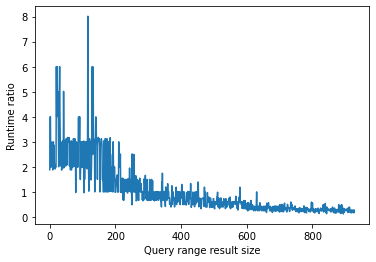

In [9]:
import time
import csv

dict_kv = DictKVStore()
our_kv = KVStore()

# Generate the entries
for i in [random.randint(1, 100000) for _ in range(50000)]:
    dict_kv[i] = i
    our_kv[i] = i
    
# Measure query times
time_ratio = []
for range_end in range(1, 1000):
        range_start = 1

        start = time.time()
        dict_kv.range_query(range_start, range_end)
        end = time.time()
        dict_time = end - start
        

        start = time.time()
        our_kv.range_query(range_start, range_end)
        end = time.time()
        our_time = end - start
        
        if our_time > 0.0:
            time_ratio.append(dict_time / our_time)

        

# Plot results
import matplotlib.pyplot as plt
plt.plot(time_ratio)
plt.xlabel('Query range result size')
plt.ylabel('Runtime ratio')
plt.show()
    
    
    

    